# DSTI
## S21: Applied MSc in Data Science & Artificial Intelligence
### **Python Lab Project: Stroke Prediction Model**
#### Instructor: Hanna Abi Akl
#### Student: Constant Patrice A. Kodja Adjovi
#### Period: Mars 2024

The goal of this project is to predict whether a patient is likely to get as **stroke** based on 10 input parameters:
**gender, age, hypertension, heart disease, ever married, work type, residence_type, average glucose level, body mass index**
and **smoking status**.

In [150]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest,chi2,f_classif
from scipy.stats import chi2_contingency
import statsmodels.api
from imblearn.over_sampling import SMOTE
import pickle

In [2]:
raw_data = pd.read_csv("datasets/stroke_data.csv",sep=",",index_col="id")

In [3]:
df_PrePro = raw_data.copy()  # Copy for data preprocessing

## Data Exploration Analysis

In [4]:
df_PrePro.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
df_PrePro.tail()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0
44679,Female,44.0,0,0,Yes,Govt_job,Urban,85.28,26.2,Unknown,0


The dataset has the two types of variables: the **numerical** and the **categorical**.
The categorical variables are from **ordinal** and **nominal type**.

I used the observations ID is used as rows identifier.

In [6]:
df_PrePro.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


The dataset has one response variable **stroke** which is a categorical and 10 explanatory variables as features.
Based on the above structure there are 7 **categorical features** and 3 **numerical features**.

Within the categorical features there are 5 nominal variables that's why they are not displayed in the above describe table.

**Missing data:**
The feature **bmi** has missing values (NaN); that's why it does not have a total of 5110 observations. The feature structure according to the "stroke" will be checked in order to see if the observations or row liked to those NaN should deleted or imputed with a kind of 'bmi' mean.

**Bias hypothesis:**
The dataset seems unbalanced by comparing the means and the maximum of features:
Stroke, hypertension, heart-disease and bmi have their means far from O.5. This is due to the size of the small observations (less than 10,000).
This will likely push the model to predict between the large size values.

**Outlier hypothesis:**
Numerical features like **BMI** and **Average Glucose Level** seem to have outliers. Their **means** are close to the **min value** than to the **max**.
With this the means would seem incorrect and this could present **data imbalance** for the model which will likely prefer predict more for one side than the other.
**age** feature looks more balanced.

#### Target variable "stroke" data analysis

In [7]:
df_PrePro.stroke.value_counts()

stroke
0    4861
1     249
Name: count, dtype: int64

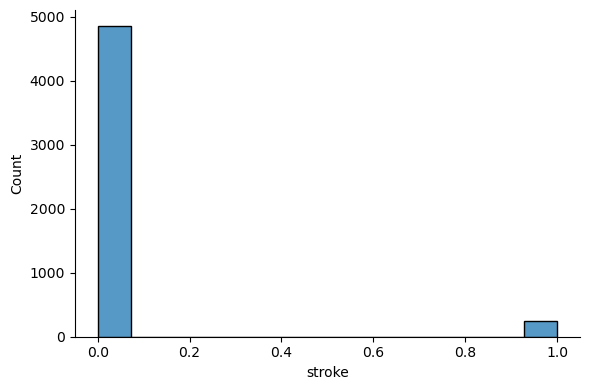

In [8]:
sns.displot(df_PrePro.stroke,height=4, aspect=1.5)

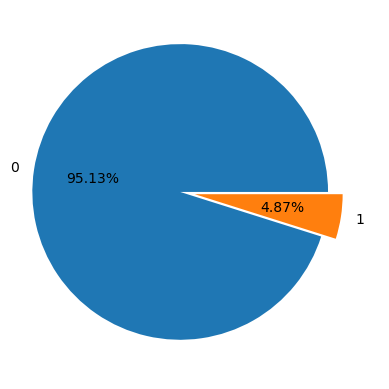

In [9]:
plt.pie(df_PrePro.stroke.value_counts(),labels=df_PrePro.stroke.value_counts().index,autopct='%1.2f%%',explode=[0.1,0])
plt.savefig("images/stroke_structure.png")
plt.show()

The response variable **stroke** is hugely unbalanced and will really push the model to more predict unstroke cases.

------------------------------------------------------

#### Explanatory variables data analysis

##### Gender data analysis

The study text indicates that there is **Other** as gender. We will check the number of observations concerned

In [10]:
df_PrePro.gender.value_counts()

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

In [11]:
#As only one within 5110 observations which is concerned we cannot remove it without a negative impact on the dataset

indexOther = df_PrePro[(df_PrePro['gender'] == "Other")].index
df_PrePro.drop(indexOther , inplace=True)

In [12]:
df_PrePro.gender.describe()

count       5109
unique         2
top       Female
freq        2994
Name: gender, dtype: object

In [13]:
df_PrePro.gender.value_counts()

gender
Female    2994
Male      2115
Name: count, dtype: int64

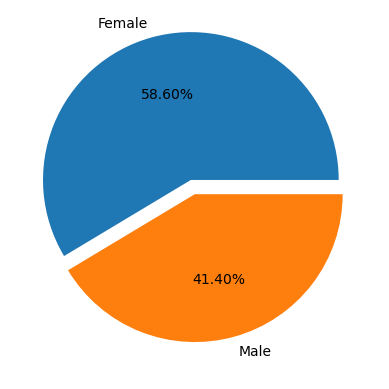

In [14]:
plt.pie(df_PrePro.gender.value_counts(),labels=df_PrePro.gender.value_counts().index,autopct='%1.2f%%',explode=[0.1,0])
plt.show()

C:\ProgramData\anaconda3\envs\env_strokepred\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\ProgramData\anaconda3\envs\env_strokepred\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\ProgramData\anaconda3\envs\env_strokepred\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


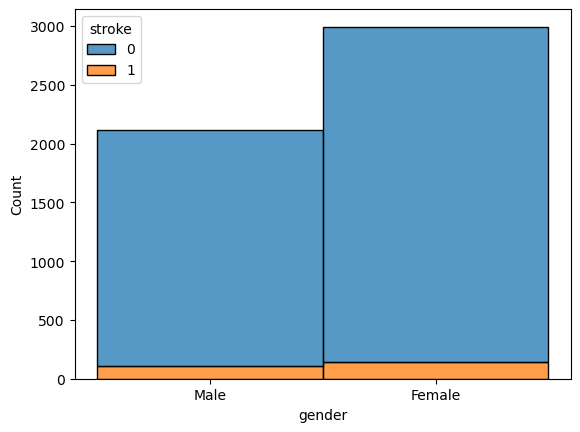

In [15]:
sns.histplot(x=('gender'),hue=('stroke'),multiple="stack",data=df_PrePro)
plt.show()

In [16]:
((df_PrePro.loc[:,["stroke","gender"]]).value_counts())/len(df_PrePro)*100

stroke  gender
0       Female    55.842631
        Male      39.283617
1       Female     2.759836
        Male       2.113917
Name: count, dtype: float64

Females seem to slightly have more stroke than males: **2.76% for Female** and **2.11% for Male**

----------------------------------------------------------------------------------------------

##### BMI data analysis

In [17]:
df_PrePro.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [18]:
#There is a confimation of 4% of missing value inside the column bmi  (201).
print(round(201/5110*100),'%')

4 %


In [19]:
df_PrePro.loc[df_PrePro.bmi.isna(),["stroke","age","bmi"]].groupby("stroke").count()

,age,bmi
stroke,,
0,161,0
1,40,0


**BMI** has 40 missing values within the 249 stroked people so we won't delete them.
We notice above that within the 201 bmi missing values we have 161 for unstroked observations and 40 for the other.
We could replace NaN values by the bmi feature average but we will try to do it according to stroke groups means.
So the 161 will be imputed with the unstroked mean and stroke one for the 40.

In [20]:
indexNaUnstroke= df_PrePro.loc[df_PrePro.bmi.isna(),:][(df_PrePro['stroke'] == 0)].index
indexNaStroke= df_PrePro.loc[df_PrePro.bmi.isna(),:][(df_PrePro['stroke'] == 1)].index
print(len(indexNaStroke),'and',len(indexNaUnstroke))

40 and 161


C:\Users\P.Kodja\AppData\Local\Temp\ipykernel_29632\2926388912.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  indexNaUnstroke= df_PrePro.loc[df_PrePro.bmi.isna(),:][(df_PrePro['stroke'] == 0)].index
C:\Users\P.Kodja\AppData\Local\Temp\ipykernel_29632\2926388912.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  indexNaStroke= df_PrePro.loc[df_PrePro.bmi.isna(),:][(df_PrePro['stroke'] == 1)].index


In [21]:
bmiUnstrokeMean=round(df_PrePro.loc[(df_PrePro['stroke'] == 0)].bmi.mean(),1)
bmiStrokeMean=round(df_PrePro.loc[(df_PrePro['stroke'] == 1)].bmi.mean(),1)
print(bmiStrokeMean,'and',bmiUnstrokeMean)

30.5 and 28.8


In [22]:
df_PrePro.loc[indexNaUnstroke,"bmi"] = bmiUnstrokeMean
df_PrePro.loc[indexNaStroke,"bmi"] = bmiStrokeMean

In [23]:
#df_PrePro.bmi.isna().index
df_PrePro.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [24]:
df_PrePro.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000
mean,43.229986,0.097475,0.054022,106.140399,28.904150,0.048738
std,22.613575,0.296633,0.226084,45.285004,7.699558,0.215340
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.240000,23.800000,0.000000
50%,45.000000,0.000000,0.000000,91.880000,28.400000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,32.800000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


There is not a significant difference between **bmi** means before (**28.89456**) and after (**28.904150**)

##### **Numeric features outliers checking**

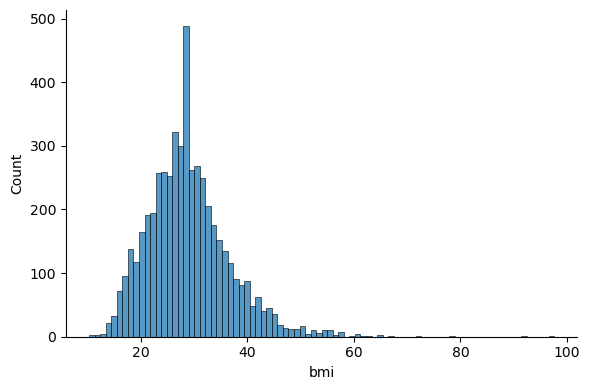

In [25]:
sns.displot(df_PrePro.bmi,height=4, aspect=1.5)
plt.savefig("images/bmi_hist.png")
plt.show()

C:\ProgramData\anaconda3\envs\env_strokepred\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


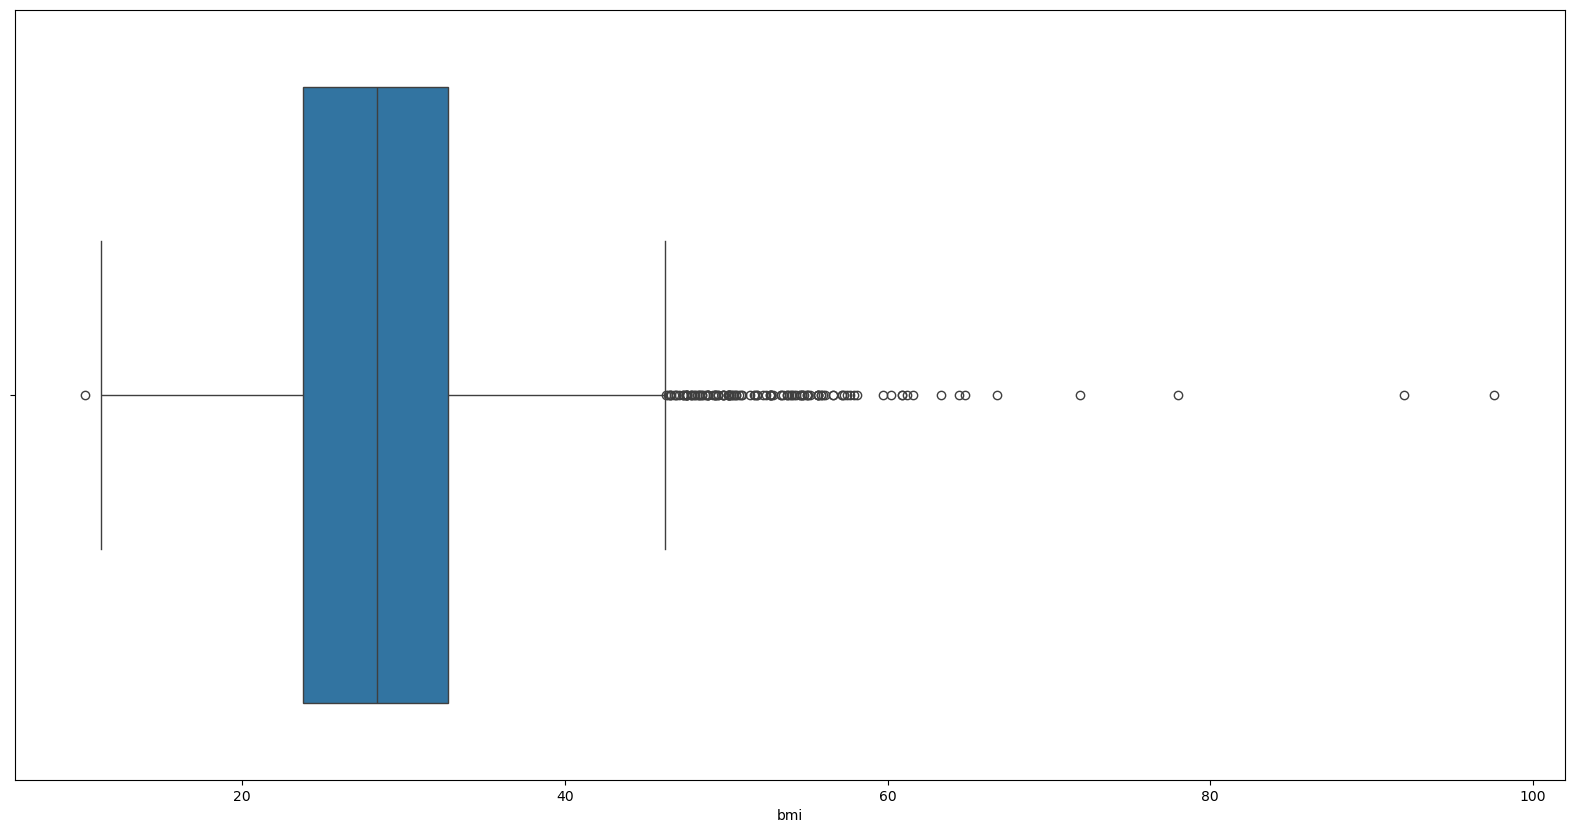

In [26]:
plt.figure(figsize=(20,10))
sns.boxplot(x=df_PrePro.bmi)
plt.savefig("images/bmi_boxplot.png")
plt.show()

**BMI feature** seems to have **outlier values** after 80. This has negative impact on the mean and the median use would be better.
As the the outliers frequencies are low, the model is likely to not predict the related observation in that range based on their limited number.
This introduces data **imbalance** which could be resolved with more observations that we do not have. Outliers could also be cut to ajust data range but cautious must be taken and further anakyses must be conducted first.

----------------------------------------------------------------------------------

##### **avg_glucose_level data analysis**

C:\ProgramData\anaconda3\envs\env_strokepred\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\ProgramData\anaconda3\envs\env_strokepred\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\ProgramData\anaconda3\envs\env_strokepred\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


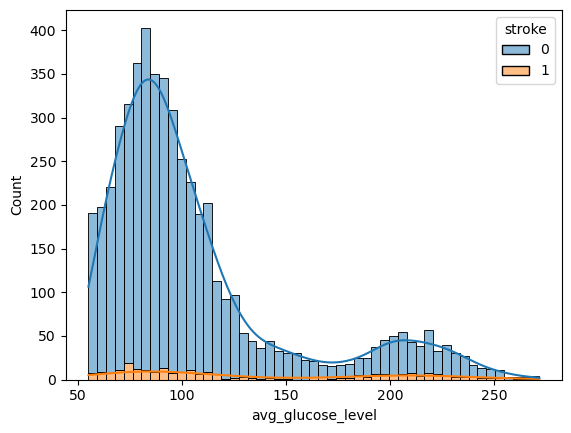

In [27]:
#sns.displot(df_PrePro.avg_glucose_level,height=4, aspect=1.5)
sns.histplot(x=('avg_glucose_level'),hue=('stroke'),multiple="stack",kde=True,data=df_PrePro)
plt.savefig("images/avg_glucose_level.png")
plt.show()


In [28]:
df_PrePro.avg_glucose_level.describe()

count    5109.000000
mean      106.140399
std        45.285004
min        55.120000
25%        77.240000
50%        91.880000
75%       114.090000
max       271.740000
Name: avg_glucose_level, dtype: float64

Above figures confirm the graph results.
The **median (91.88)** is inferier to the **mean (106.14)** proving that the data has **right skewness** indicating outliers presence as the median is close to the **min 55.12** and far from the **max 271.74**.
This could be the consequence of the small data size (number of observations).
At this stage, data is unbalanced and will impact negatively the model training and prediction.

Besides, the feature seems to be a **bimodal** column even though the second mode frequence is less than 100, the model can take it into account during the training steps and the prediction of typical observation (typically concentrated around the mean or the median) will be negatively impacted if the model is accustomed to outliers.

Based on the feature structure and limited data size, it would be better to choose adequate statistic model which handles outliers.

The stroke seems following the same trend like the feature data.

In [29]:
print("# avg glucose level for fasting blood in [70, 100] (normal case) :", 
      df_PrePro.loc[((df_PrePro.avg_glucose_level > 70) & (df_PrePro.avg_glucose_level < 100)),:].avg_glucose_level.count())
print("# Maximum of avg glucose level for all must be < 125 (over all or general case): ", 
      df_PrePro.loc[df_PrePro.avg_glucose_level <= 125,:].avg_glucose_level.count())
print("# avg glucose level > 125 (Consider dangerous) :", 
      df_PrePro.loc[df_PrePro.avg_glucose_level > 125,:].avg_glucose_level.count())

# avg glucose level for fasting blood in [70, 100] (normal case) : 2375
# Maximum of avg glucose level for all must be < 125 (over all or general case):  4110
# avg glucose level > 125 (Consider dangerous) : 999


The above graph proves the bimodal characteristic of the feature data with the strocke display.
We notice a concentration around the first median 91.88 which decreases and seem close to zero around 150 (< 125 the maximum tolorated)

C:\ProgramData\anaconda3\envs\env_strokepred\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\ProgramData\anaconda3\envs\env_strokepred\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\ProgramData\anaconda3\envs\env_strokepred\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


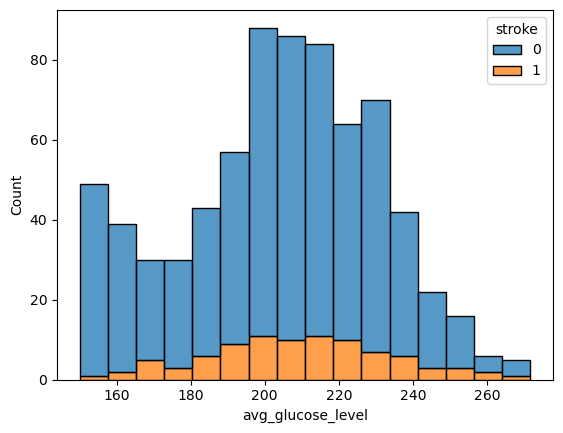

In [30]:
sns.histplot(x=('avg_glucose_level'),hue=('stroke'),multiple="stack",data=df_PrePro[df_PrePro.avg_glucose_level >=150.0])
plt.show()

In [31]:
df_PrePro[df_PrePro.avg_glucose_level >=150.0].avg_glucose_level.describe()

count    731.000000
mean     203.828577
std       26.774624
min      150.000000
25%      186.495000
50%      205.840000
75%      222.490000
max      271.740000
Name: avg_glucose_level, dtype: float64

This part of date seems having almost normal distribution charactéristic could be separated from the main part into another explanatory variable.
But these values are extremes ones (>125) and their number is not sufficient enough to be a separate variable.

Maybe one of solution would be to remove those observations in order to a balanced normal data for models training as we cannot provide more observation data.

--------------------------------------------------------------------------------------------------

##### **Age data analysis**

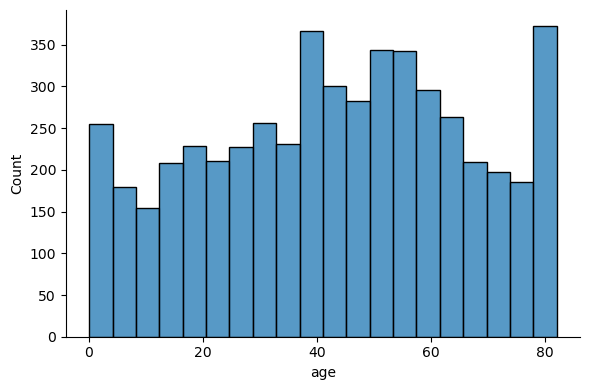

In [32]:
sns.displot(df_PrePro.age,height=4, aspect=1.5)

C:\ProgramData\anaconda3\envs\env_strokepred\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


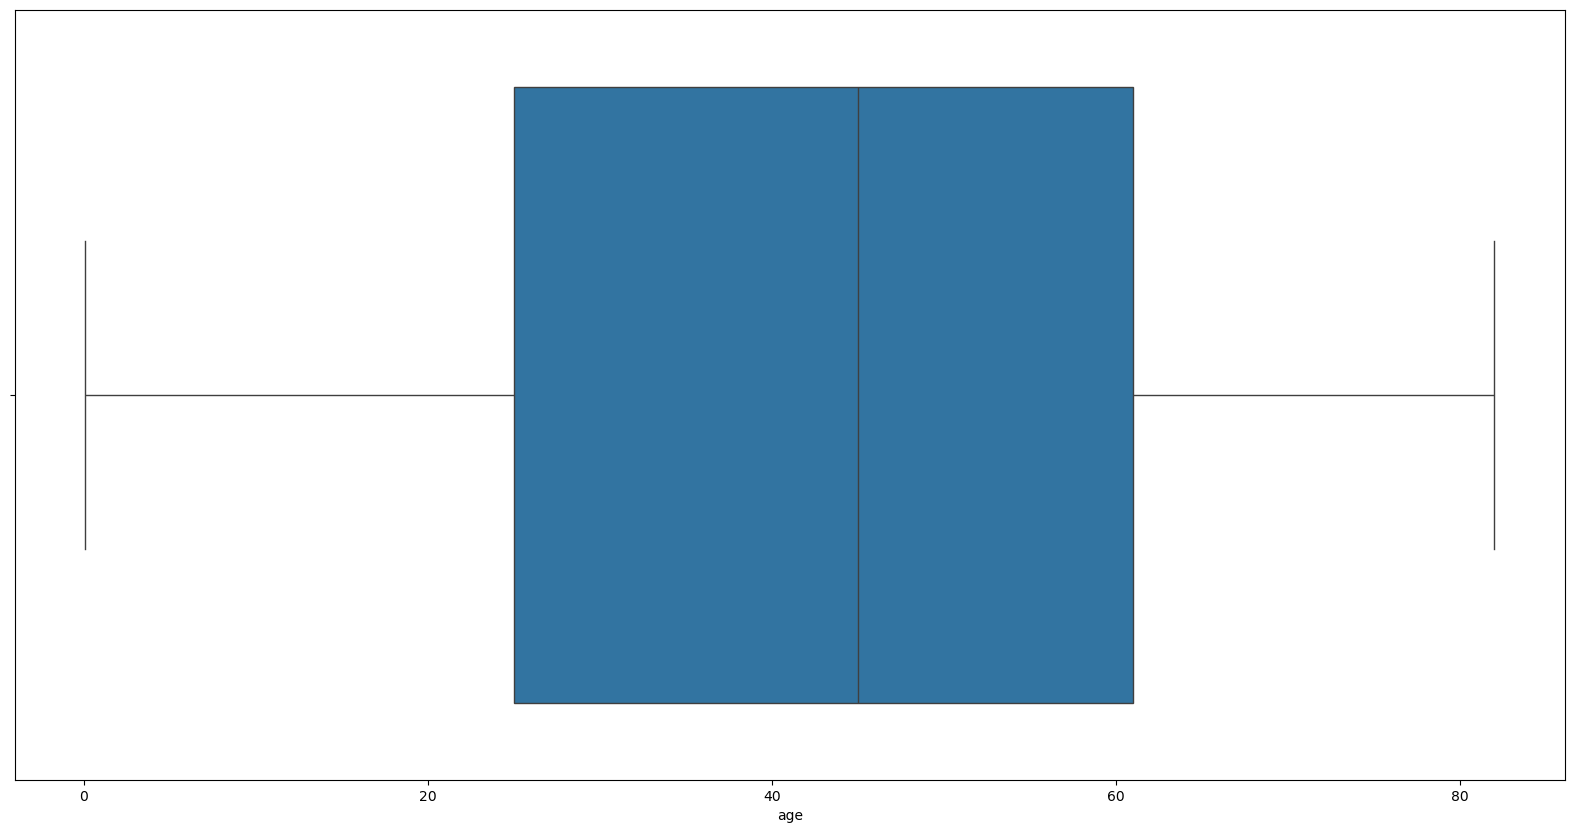

In [33]:
plt.figure(figsize=(20,10))
sns.boxplot(x=df_PrePro.age)
plt.savefig("images/age_boxplot.png")
plt.show()

C:\ProgramData\anaconda3\envs\env_strokepred\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\ProgramData\anaconda3\envs\env_strokepred\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\ProgramData\anaconda3\envs\env_strokepred\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


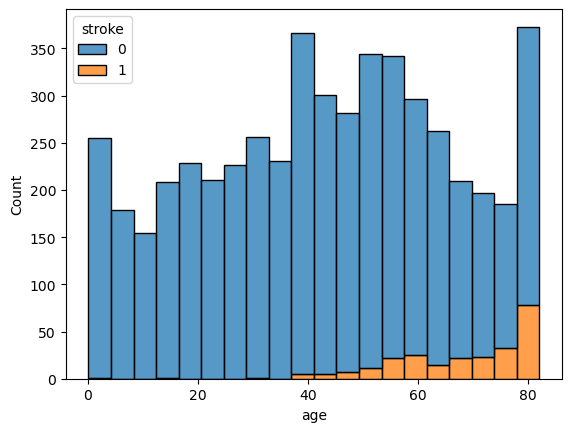

In [34]:
sns.histplot(x=('age'),hue=('stroke'),multiple="stack",data=df_PrePro)
plt.savefig("images/age_hist.png")
plt.show()

C:\ProgramData\anaconda3\envs\env_strokepred\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\ProgramData\anaconda3\envs\env_strokepred\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\ProgramData\anaconda3\envs\env_strokepred\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


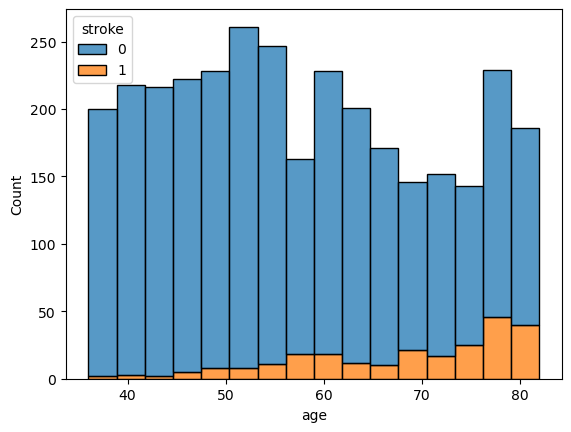

In [35]:
sns.histplot(x=('age'),hue=('stroke'),multiple="stack",data=df_PrePro[df_PrePro.age >=35.1])
plt.show()

In [36]:
df_PrePro.age[df_PrePro.age >=35.1].min(), df_PrePro.age[df_PrePro.age >=35.1].max()

(36.0, 82.0)

Age feature seems a balanced data without outlier values.
The stroke seems to happen between ages 36 to 82 and seem to have increase trend as ages are increasing.

------------------------------------------------------

##### **Hypertension data analysis**

C:\ProgramData\anaconda3\envs\env_strokepred\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\ProgramData\anaconda3\envs\env_strokepred\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\ProgramData\anaconda3\envs\env_strokepred\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


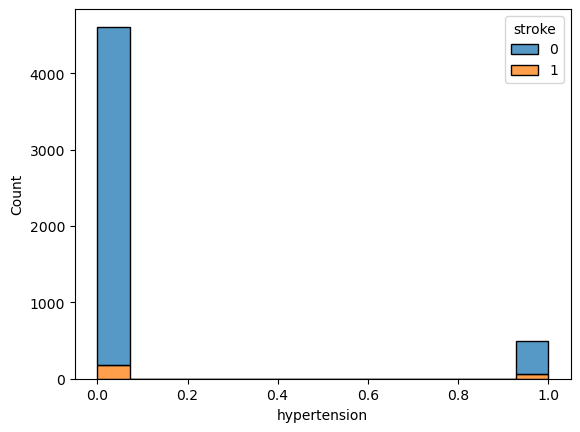

In [37]:
sns.histplot(x=('hypertension'),hue=('stroke'),multiple="stack",data=df_PrePro)
plt.savefig("images/hypertension.png")
plt.show()

In [38]:
df_PrePro.hypertension.value_counts()

hypertension
0    4611
1     498
Name: count, dtype: int64

In [39]:
((df_PrePro.loc[:,["stroke","hypertension"]]).value_counts())/len(df_PrePro)*100

stroke  hypertension
0       0               86.670581
        1                8.455666
1       0                3.581914
        1                1.291838
Name: count, dtype: float64

**Unbalanced data**: large number of non-hypertension people than the hypertension people.
According to the data, it seems to have **more stroke within non-hypertension people**.
The lack of sufficient observations could lead to this as those who have the stroke also have the hypertension disease.

------------------------------------------------------

##### **Heart disease data analysis**

C:\ProgramData\anaconda3\envs\env_strokepred\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\ProgramData\anaconda3\envs\env_strokepred\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\ProgramData\anaconda3\envs\env_strokepred\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


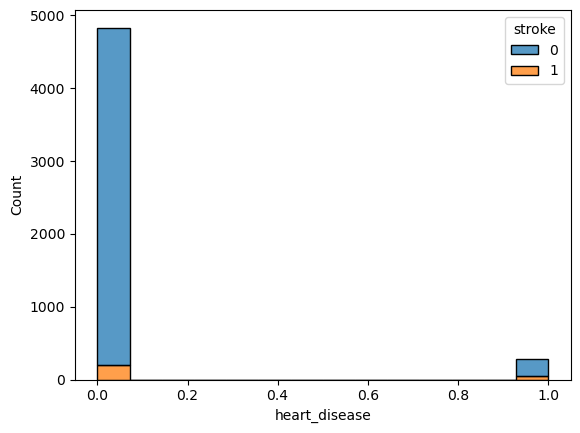

In [40]:
sns.histplot(x=('heart_disease'),hue=('stroke'),multiple="stack",data=df_PrePro)  
plt.savefig("images/heart_disease.png")
plt.show()

Seems almost the same thing like for hypertension: more strokes happen within people who do not have heart disease.
The lack of sufficient observations could lead to this as those who have the stroke also have the heart disease.

------------------------------------------------------

##### **Work Type data analysis**

C:\ProgramData\anaconda3\envs\env_strokepred\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\ProgramData\anaconda3\envs\env_strokepred\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\ProgramData\anaconda3\envs\env_strokepred\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


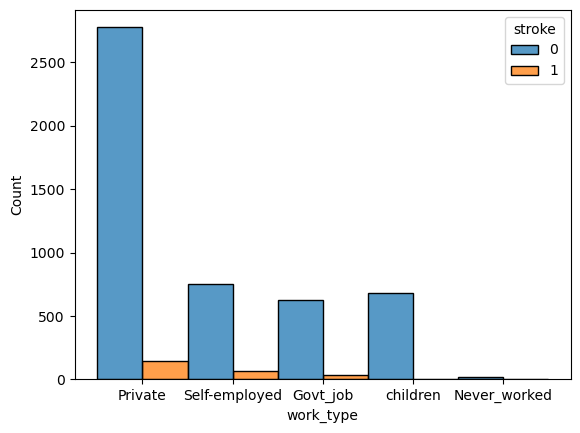

In [41]:
sns.histplot(x=('work_type'),hue=('stroke'),multiple="dodge",data=df_PrePro)   #multiple="stack" can also be used
plt.savefig("images/work_type.png")
plt.show()

In [42]:
(df_PrePro.loc[:,["stroke","work_type"]]).value_counts()

stroke  work_type    
0       Private          2775
        Self-employed     754
        children          685
        Govt_job          624
1       Private           149
        Self-employed      65
        Govt_job           33
0       Never_worked       22
1       children            2
Name: count, dtype: int64

The above result is sorted according to the frequencies.
Private, self-employed and Government job people used to have strock with the highest part for the **private sector** and then follow **Self-employed people**. This is proved that those who face more economical challenges used to have more stroke within them Conversely, people working for the government have fewer strokes than the private sector as a whole.

People who have never worked and children do not have strokes or are less likely to experience them.
This feature seems to have an impact on the target variable.

------------------------------------------------------

##### **Ever Married data analysis**

C:\ProgramData\anaconda3\envs\env_strokepred\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\ProgramData\anaconda3\envs\env_strokepred\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\ProgramData\anaconda3\envs\env_strokepred\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


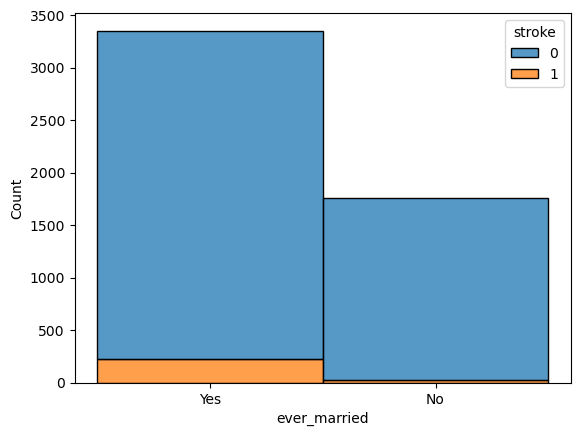

In [43]:
sns.histplot(x=('ever_married'),hue=('stroke'),multiple="stack",data=df_PrePro)  
plt.savefig("images/ever_married.png")
plt.show()

In [44]:
(df_PrePro.loc[:,["stroke","ever_married"]]).value_counts()

stroke  ever_married
0       Yes             3133
        No              1727
1       Yes              220
        No                29
Name: count, dtype: int64

Married people seem to more have stroke than the others who have less stroke.
There is data imbalance between the two classes

------------------------------------------------------

##### **Smoking status data analysis**

C:\ProgramData\anaconda3\envs\env_strokepred\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\ProgramData\anaconda3\envs\env_strokepred\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\ProgramData\anaconda3\envs\env_strokepred\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


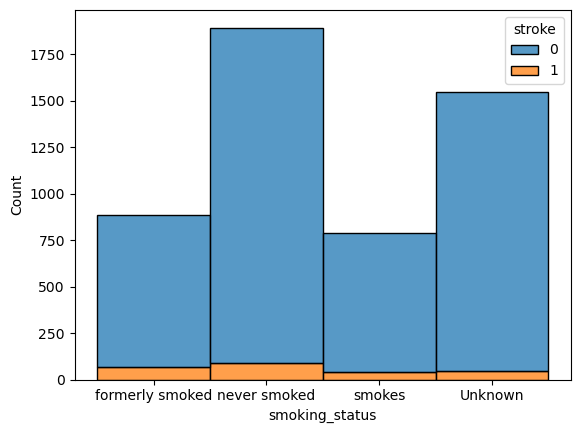

In [45]:
sns.histplot(x=('smoking_status'),hue=('stroke'),multiple="stack",data=df_PrePro)  
plt.savefig("images/smoking_status.png")
plt.show()

In [46]:
(df_PrePro.loc[:,["stroke","smoking_status"]]).value_counts()

stroke  smoking_status 
0       never smoked       1802
        Unknown            1497
        formerly smoked     814
        smokes              747
1       never smoked         90
        formerly smoked      70
        Unknown              47
        smokes               42
Name: count, dtype: int64

Here people who never smoked are in a high number within the dataset and they are the ones having more stroke than those who have formerly smoked which number is inferior to never smoked people. This could may be caused by the limited number of observation in formerly smoked class.
Same for the smoked class which has less stroked people than never smoked class.

------------------------------------------------------

### Multiple features comparing graphs

#### Hypertension, smoking_status and stroke

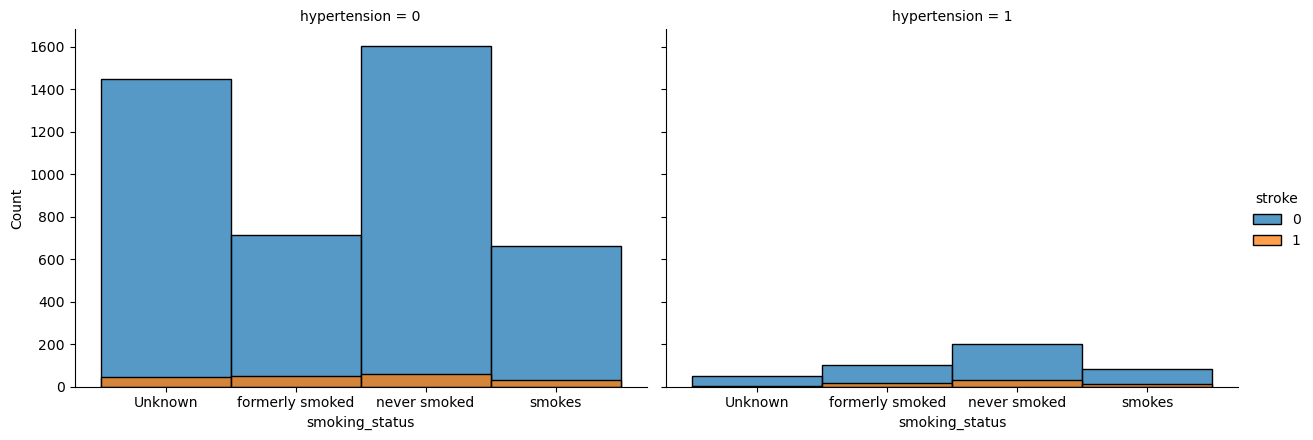

In [47]:
g = sns.FacetGrid(df_PrePro, col="hypertension",hue="stroke", height=4.5, aspect=1.4)
g.map(sns.histplot, "smoking_status")
g.add_legend()
g.savefig("images/Hypertension_Smoking_Stroke.png")

People who have never smoked and those who have stopped smoking face stroke issue and the risk exist if they have hypertension.

----------

#### Hypertension, avg_glucose_level, ever_married and stroke

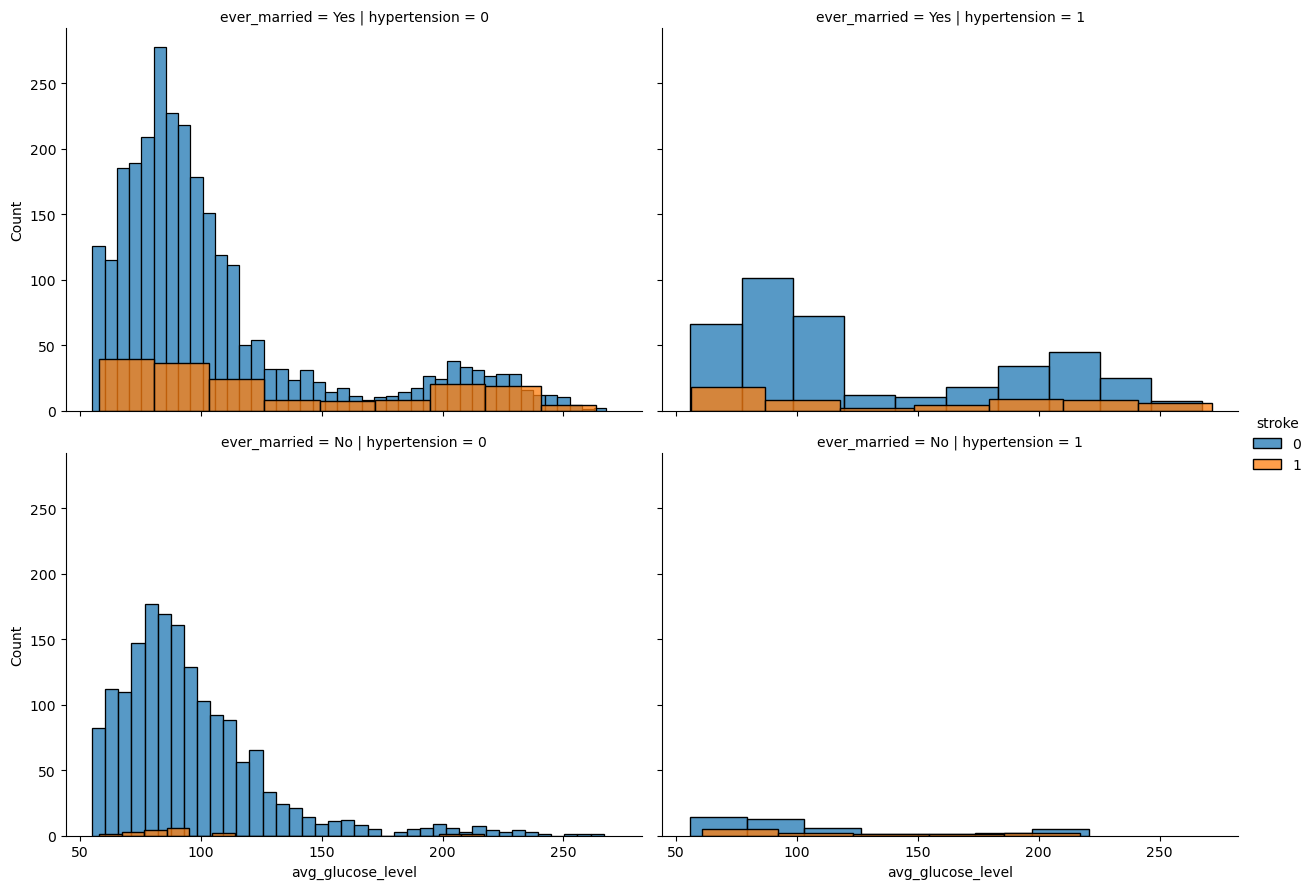

In [48]:
g = sns.FacetGrid(df_PrePro, col="hypertension",row="ever_married",hue="stroke", height=4.5, aspect=1.4)
g.map(sns.histplot, "avg_glucose_level")
g.add_legend()
g.savefig("images/_GlucoseHypertension_Married_Stroke.png")

Married people with high average glucose level than normal have high stroke rate. The risk seems less for the same people with hypertension

------------------------------------------------

#### Hypertension, avg_glucose_level, heart_disease and stroke

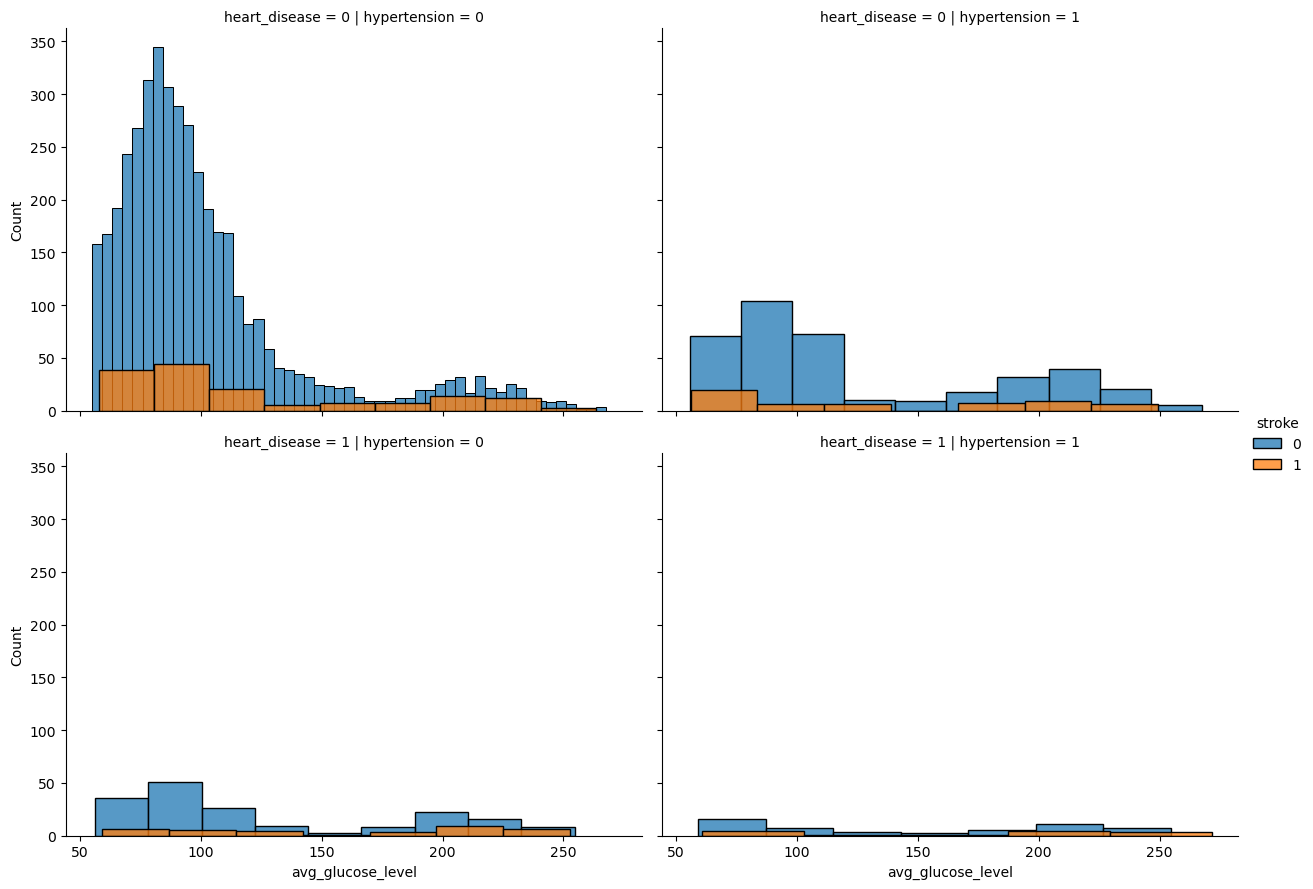

In [49]:
g = sns.FacetGrid(df_PrePro, col="hypertension",row="heart_disease",hue="stroke", height=4.5, aspect=1.4)
g.map(sns.histplot, "avg_glucose_level")
g.add_legend()
g.savefig("images/_GlucoseHypertension_HeartDisease_Stroke.png")

As we discussed earlier, people with average glucose levels between 70 and 125 have a high rate of stroke, regardless of heart disease or hypertension.
Within them, those with hypertension also a bit more chance to face stroke.

------------

#### Hypertension, age, ever_married and stroke

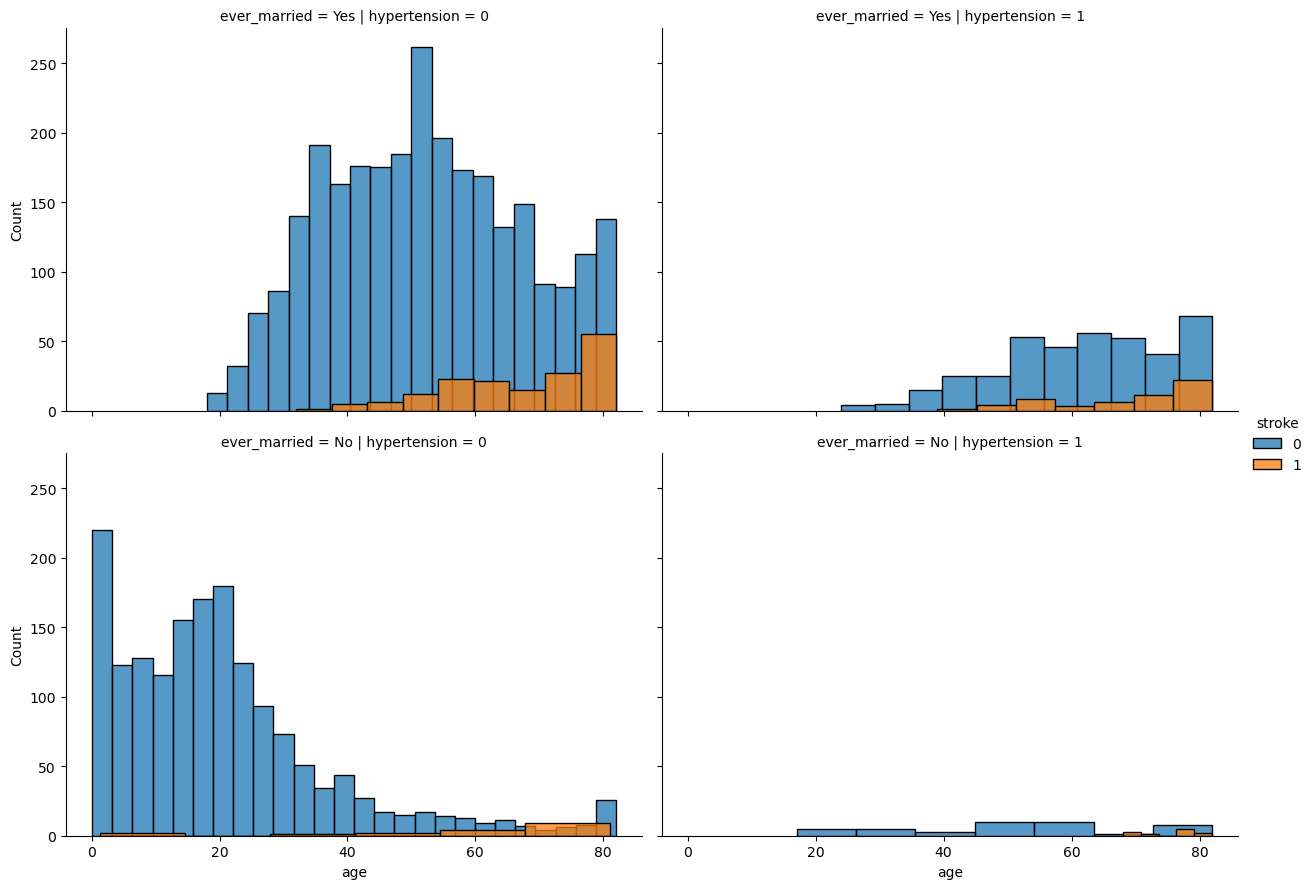

In [50]:
g = sns.FacetGrid(df_PrePro, col="hypertension",row="ever_married",hue="stroke", height=4.5, aspect=1.4)
g.map(sns.histplot, "age")
g.add_legend()
g.savefig("images/Age_Hypertension_Married_Stroke.png")

In most cases old people have more chances to have a stroke. Those within them who are married seems the most impacted according to the current data.
Those who are old, married and have hypertension have stroke.

----------------------------------------

#### Hypertension, age, heart_disease and stroke

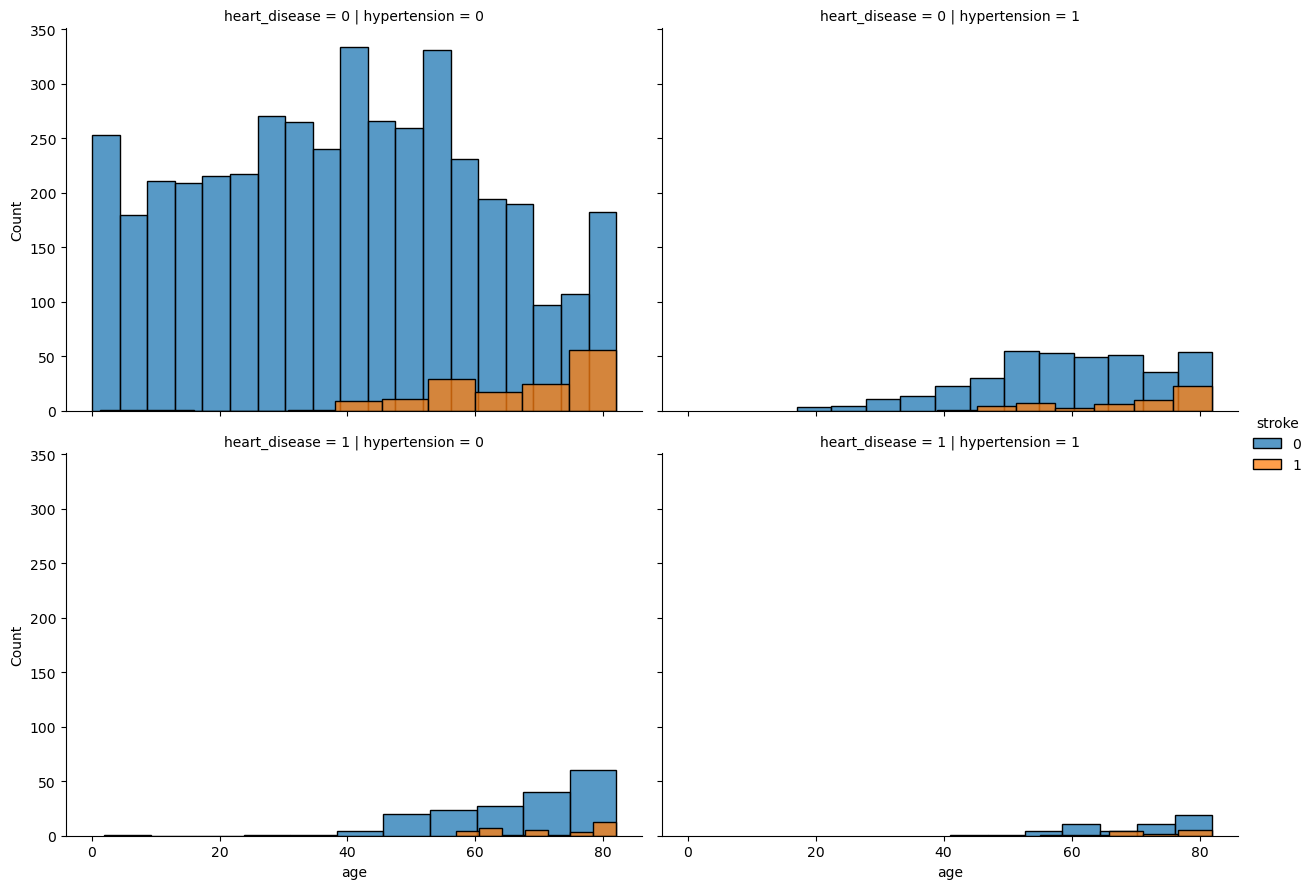

In [51]:
g = sns.FacetGrid(df_PrePro, col="hypertension",row="heart_disease",hue="stroke", height=4.5, aspect=1.4)
g.map(sns.histplot, "age")
g.add_legend()
g.savefig("images/AgeHypertension_HeartDisease_Stroke.png")

Old people with heart_disease face less strok than those without a heart_disease

---------------------------------------------------------------

#### Hypertension, age, avg_glucose_level and stroke

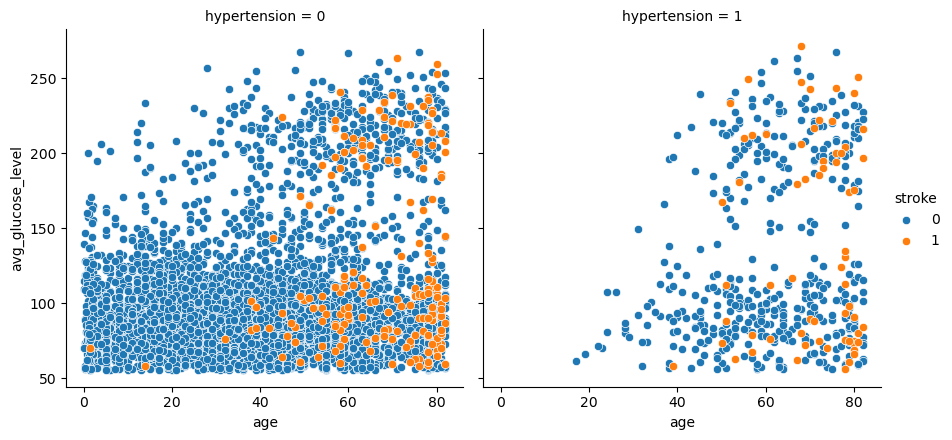

In [52]:
g = sns.FacetGrid(df_PrePro, col="hypertension", hue="stroke", height=4.5, aspect=1)
g.map_dataframe(sns.scatterplot, x="age", y="avg_glucose_level")
g.add_legend()
g.savefig("images/Age_Glucose_Hypertension_Stroke.png")

Most people seem to have an average blood sugar below 125, regardless of age, but strokes occur among them in people over 50 years old.
The data imbalance does not allow to really notice the hypertension impact on those people but we have the same trend for old people with hypertension.

----------------------------------------

## Feature Engineering and variables selection

Features data transformation and features correlation will studied here in order to select relevant variable for the classification model

### 1-Data transformation

They will be two data transformations for the **categorical variables**: one just for feature correlation study with pandas corr() function which needs numerical values and later will be feature transformation for the model use.

In [53]:
df_transf= df_PrePro.copy() # Temporary dataframe for feature transformation for correlation computation and analysis

In [54]:
labelClassEncod = {} # A dictionnary variable to keep the label order after transform use

In [55]:
# CONVERSION STRING TO INTEGER
# A function is designed in order to avoid codes repeating.
# LabelEncoder() of sklearn.preprocessing is used
# "featureColumn": DataFrame column which is nominal categorical variable, "featureLabelList": The column lables to be coded


def labelEncodeFunc(featureColumn,featureLabelList):
    global labelClassEncod
    if isinstance((df_transf.loc[(df_transf.loc[:,featureColumn]).index[0],featureColumn]),str):
        encodeMethod=LabelEncoder()
        encodeMethod.fit(featureLabelList) # Gender column labels
        
        # Column "featureColumn" values order saving in the Dictionnary
        labelClassEncod[featureColumn]=list(encodeMethod.classes_)
        
        #The transformation use on the column "featureColumn"
        featureTransformed = encodeMethod.transform(df_transf.loc[:,featureColumn])
        df_transf.loc[:,featureColumn]=featureTransformed
    
        return list(encodeMethod.classes_), df_transf.loc[:,featureColumn]
    else :
        # labelClassEncod[featureColumn] will display the former "featureColumn" transformation saved in the dictionary
        return labelClassEncod[featureColumn], df_transf.loc[:,featureColumn]

In [56]:
# Gender column transformation in 0 (Female) and 1 (Male)
labelEncodeFunc("gender",["Female","Male"])

(['Female', 'Male'],
 id
 9046     1
 51676    0
 31112    1
 60182    0
 1665     0
         ..
 18234    0
 44873    0
 19723    0
 37544    1
 44679    0
 Name: gender, Length: 5109, dtype: object)

In [57]:
# ever_married column transformation in 0 (No) and 1 (Yes)
labelEncodeFunc("ever_married",["No","Yes"])

(['No', 'Yes'],
 id
 9046     1
 51676    1
 31112    1
 60182    1
 1665     1
         ..
 18234    1
 44873    1
 19723    1
 37544    1
 44679    1
 Name: ever_married, Length: 5109, dtype: object)

In [58]:
# work_type column transformation in 0,1,2,3,4 in the order 'Govt_job', 'Never_worked', 'Private', 'Self-employed', 'children'
labelEncodeFunc("work_type",["Private","Self-employed","children","Govt_job","Never_worked"])

(['Govt_job', 'Never_worked', 'Private', 'Self-employed', 'children'],
 id
 9046     2
 51676    3
 31112    2
 60182    2
 1665     3
         ..
 18234    2
 44873    3
 19723    3
 37544    2
 44679    0
 Name: work_type, Length: 5109, dtype: object)

In [59]:
# Residence_type column transformation in 0 ('Rural') and 1 (Urban')
labelEncodeFunc("Residence_type",["Rural","Urban"])

(['Rural', 'Urban'],
 id
 9046     1
 51676    0
 31112    0
 60182    1
 1665     0
         ..
 18234    1
 44873    1
 19723    0
 37544    0
 44679    1
 Name: Residence_type, Length: 5109, dtype: object)

In [60]:
# smoking_status column transformation in the following order 'Unknown', 'formerly smoked', 'never smoked', 'smokes'
labelEncodeFunc("smoking_status",["never smoked","formerly smoked","smokes","Unknown"])

(['Unknown', 'formerly smoked', 'never smoked', 'smokes'],
 id
 9046     1
 51676    2
 31112    2
 60182    3
 1665     2
         ..
 18234    2
 44873    2
 19723    2
 37544    1
 44679    0
 Name: smoking_status, Length: 5109, dtype: object)

In [61]:
#All label order printing
labelClassEncod

{'gender': ['Female', 'Male'],
 'ever_married': ['No', 'Yes'],
 'work_type': ['Govt_job',
  'Never_worked',
  'Private',
  'Self-employed',
  'children'],
 'Residence_type': ['Rural', 'Urban'],
 'smoking_status': ['Unknown', 'formerly smoked', 'never smoked', 'smokes']}

In [62]:
df_transf.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,1,67.0,0,1,1,2,1,228.69,36.6,1,1
51676,0,61.0,0,0,1,3,0,202.21,30.5,2,1
31112,1,80.0,0,1,1,2,0,105.92,32.5,2,1
60182,0,49.0,0,0,1,2,1,171.23,34.4,3,1
1665,0,79.0,1,0,1,3,0,174.12,24.0,2,1


### 2-Feature correlation study and variable selection

The above dataframe is arrange in numeric values to use Pearson statistic test with pandas **df_transf.corr()** below

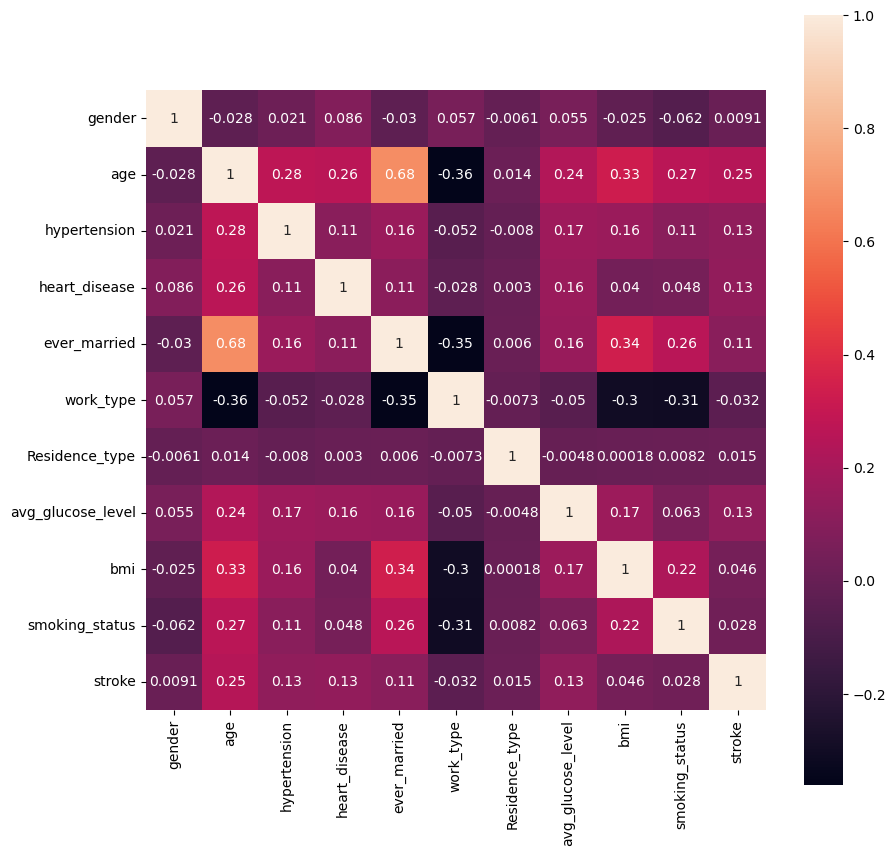

In [63]:
#needs seaborn version 0.13.0
plt.figure(figsize=(10,10))
sns.heatmap(df_transf.corr(),annot=True,square=True)
plt.savefig("images/corr_plot.png")
plt.show()

**Correlation hypotheses from the above results**

- **age**, **hypertension**, **heart-disease**, **ever_married** and **avg_glucose_level** seem strongly correlated with the target variable **stroke**
- Between **stroke** and explanatory variables:
      only **"gender" and "Residence_type"** seem not correlated to response variable stroke.
      only **"work_type"** is negatively correlated to stroke
  
- Between **explanatory variables**:
      **"age" and "work_type"** seem negatively correlated.
      **"age"** and **"ever_married"** seem **highly** positively correlated

#### Correlations confirmation cheking in three steps:

- Correlation between numerical variable with **Pearson statistic test** with pd.corr()
- Correlation between categorical variables with **Chi2 statistic test with chi2_contingency() function**
- Correlation between numerical and categorical variables with **ANOVA test** through **"SelectKBest"** class.

1-Correlation between numerical variable with **Pearson statistic test** with pd.corr()

In [64]:
df_numeric = df_transf[['age', 'avg_glucose_level', 'bmi']]
df_numeric.corr()

,age,avg_glucose_level,bmi
age,1.000000,0.238323,0.327495
avg_glucose_level,0.238323,1.000000,0.169268
bmi,0.327495,0.169268,1.000000


There is no significant correlation between numerical variables even though age and bmi seems more correlated than the others

2-Correlation between categorical variables and the target variable **"stroke"** with **Chi2 statistic test with chi2_contingency() function**

In [65]:
def chi2CorrTest(feat1,feat2):     # e.g: df["stroke"],df["gender"]
    """
    Function of correlation computation between two categorical variables
    """
    table=pd.crosstab(feat1,feat2) 
    corr_table=chi2_contingency(table)
    #print(corr_table[0])
    print("Chi2 Test P_value:",corr_table[1])
    print(corr_table[2])
    if (corr_table[1] < 0.05):
        print("These features are '\033[94m correlated' as ''P_value'' < 0.05")
    else:
        print("These features are not correlated as ''P_value'' >= 0.05")     
    #return

In [66]:
chi2CorrTest(df_transf["gender"],df_transf["stroke"])

Chi2 Test P_value: 0.5598277580669416
1
These features are not correlated as ''P_value'' >= 0.05


In [67]:
chi2CorrTest(df_transf["hypertension"],df_transf["stroke"])

Chi2 Test P_value: 1.688936253410575e-19
1
These features are ' correlated' as ''P_value'' < 0.05


In [68]:
chi2CorrTest(df_transf["heart_disease"],df_transf["stroke"])

Chi2 Test P_value: 2.120831133146208e-21
1
These features are ' correlated' as ''P_value'' < 0.05


In [69]:
chi2CorrTest(df_transf["ever_married"],df_transf["stroke"])

Chi2 Test P_value: 1.6862856191673454e-14
1
These features are ' correlated' as ''P_value'' < 0.05


In [70]:
chi2CorrTest(df_transf["work_type"],df_transf["stroke"])

Chi2 Test P_value: 5.40903546949726e-10
4
These features are ' correlated' as ''P_value'' < 0.05


In [71]:
chi2CorrTest(df_transf["smoking_status"],df_transf["stroke"])

Chi2 Test P_value: 2.0077041756108317e-06
3
These features are ' correlated' as ''P_value'' < 0.05


In [72]:
chi2CorrTest(df_transf["Residence_type"],df_transf["stroke"])

Chi2 Test P_value: 0.29982523877153633
1
These features are not correlated as ''P_value'' >= 0.05


3-Correlation between numerical and categorical variables with **ANOVA test**

**ANOVA test with formula.api.ols().fit() and api.stats.anova_lm()**

This is to test correlation between categorical features **work_type**, **ever_married** and the numerical feature **age**

In [73]:
#import statsmodels.api
resulta=statsmodels.formula.api.ols('age~work_type',data=df_transf).fit()  
corrAgeWorkType=statsmodels.api.stats.anova_lm(resulta)

corrAgeWorkType

,df,sum_sq,mean_sq,F,PR(>F)
work_type,4.0,1.215328e+06,303831.964265,1110.246464,0.0
Residual,5104.0,1.396769e+06,273.661727,NaN,NaN


In [74]:
#import statsmodels.api
resulta=statsmodels.formula.api.ols('age~ever_married',data=df_transf).fit() 
corrAgeWorkType=statsmodels.api.stats.anova_lm(resulta)

corrAgeWorkType

,df,sum_sq,mean_sq,F,PR(>F)
ever_married,1.0,1.204583e+06,1.204583e+06,4370.69022,0.0
Residual,5107.0,1.407514e+06,2.756048e+02,NaN,NaN


**Conclusion:** above P-values (0.0 < 0.05) confirm correlations between "age" and "ever_married" and "work_type"; but as pd.corr() has previously proved the correlation coefficient of "age" and "ever_married" is high, implying a strong relationship between both.
So to avoid data redundancy a choice might be made between "age" and "ever_married".

Let check below SelectKBest class result and see

In [75]:

def kbest_Feature_Selection_clf(data_frame, target, k=5):
    """
    Selecting K-Best features for classification
    """
    feat_selector = SelectKBest(f_classif, k=k)
    _ = feat_selector.fit(data_frame.drop(target, axis=1), data_frame[target])
    
    feat_scores = pd.DataFrame()
    feat_scores["F Score"] = feat_selector.scores_
    feat_scores["P Value"] = feat_selector.pvalues_
    feat_scores["Support"] = feat_selector.get_support()
    feat_scores["Attribute"] = data_frame.drop(target, axis=1).columns
    
    return feat_scores

df_FeatSelect = df_transf # DataFrame saving for temporary operation
kbest_features = kbest_Feature_Selection_clf(df_FeatSelect, "stroke", k=5)

kbest_features = kbest_features.sort_values(["F Score", "P Value"], ascending=[False, False])
kbest_features

,F Score,P Value,Support,Attribute
1,326.799849,7.435469e-71,True,age
3,94.666779,3.506802e-22,True,heart_disease
7,90.550026,2.705303e-21,True,avg_glucose_level
2,84.919947,4.441473e-20,True,hypertension
4,60.609558,8.367747e-15,True,ever_married
8,10.928987,9.532482e-04,False,bmi
5,5.341306,2.086549e-02,False,work_type
9,4.037898,4.454172e-02,False,smoking_status
6,1.213760,2.706407e-01,False,Residence_type
0,0.421144,5.163959e-01,False,gender


Above the 5 first features have strongest F-Scores and weakest P-Values. These results were also confirmed by the previous correlation studies.
We can also add the following 3-bmi, work_type and smoking_status- but to avoid overfitting and data redundancy some will be chosen.

#### Final feature selection conclusion:

For this study 2 models will be tested fondamentally based on the use of pd.corr() and SelectKBest():
- Model1: Stroke~age,hypertension,heart_disease,avg_glucose_level (By prefering **age** and leaving out **ever_married** strongly correlated)
- Model2 Stroke~age,hypertension,heart_disease,avg_glucose_level,ever_married  (adding **ever_married** to **Model1**)

The best will be kept.

In [76]:
df_proces = df_transf.copy()

In [77]:
df_proces

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,1,67.0,0,1,1,2,1,228.69,36.6,1,1
51676,0,61.0,0,0,1,3,0,202.21,30.5,2,1
31112,1,80.0,0,1,1,2,0,105.92,32.5,2,1
60182,0,49.0,0,0,1,2,1,171.23,34.4,3,1
1665,0,79.0,1,0,1,3,0,174.12,24.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...
18234,0,80.0,1,0,1,2,1,83.75,28.8,2,0
44873,0,81.0,0,0,1,3,1,125.20,40.0,2,0
19723,0,35.0,0,0,1,3,0,82.99,30.6,2,0


In [78]:
df_PrePro_copy= df_PrePro.copy()

In [79]:
df_PrePro_copy

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,30.5,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
18234,Female,80.0,1,0,Yes,Private,Urban,83.75,28.8,never smoked,0
44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0


## MODELS

In [80]:
#Data splitting
df_train, df_test = train_test_split(df_proces,test_size = 0.2)

In [81]:
len(df_proces)

5109

In [82]:
len(df_train)

4087

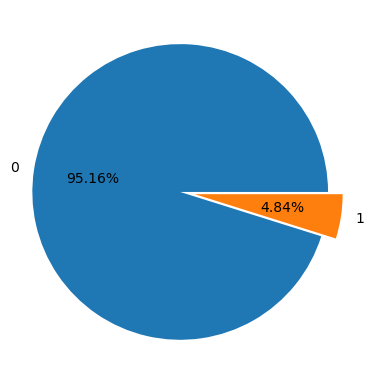

In [83]:
plt.pie(df_train.stroke.value_counts(),labels=df_train.stroke.value_counts().index,autopct='%1.2f%%',explode=[0.1,0])
plt.show()

In [84]:
len(df_test)

1022

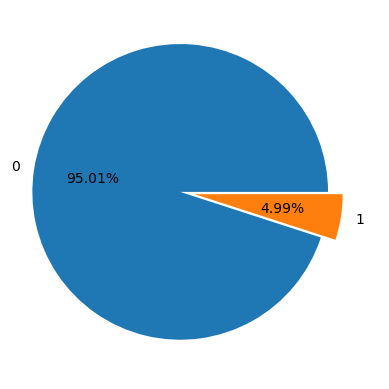

In [85]:
plt.pie(df_test.stroke.value_counts(),labels=df_test.stroke.value_counts().index,autopct='%1.2f%%',explode=[0.1,0])
plt.show()

In both datasets (Train and Test) there is a same target variable class repartition proportion 95% for unstroke and 5% for stroke; strong imbalance for the target variable "stroke" delicate for the model training.

In [86]:
df_train

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
23893,1,24.0,0,0,1,2,1,103.45,25.1,3,0
53252,1,82.0,0,0,0,3,1,161.95,30.8,2,0
63562,1,7.0,0,0,0,4,0,91.81,15.8,0,0
8960,0,42.0,0,0,0,3,0,73.41,56.0,3,0
32352,0,31.0,0,0,1,0,0,104.55,26.4,2,0
...,...,...,...,...,...,...,...,...,...,...,...
70857,0,55.0,0,0,1,0,1,198.36,29.1,3,0
820,0,59.0,1,0,1,2,0,99.06,23.4,2,0
52164,1,29.0,0,0,1,2,1,193.81,46.8,2,0


In [87]:
print(df_proces.gender.mean())
print(df_train.gender.mean())
print(df_test.gender.mean())

0.41397533763945976
0.4122828480548079
0.4207436399217221


In [88]:
print(df_proces.stroke.mean())
print(df_train.stroke.mean())
print(df_test.stroke.mean())

0.04873752201996477
0.048446293124541226
0.049902152641878667


Mean seems the same in the same column across the three datasets. The model training result can be applied on global dataset later.

#### Features extraction for models use

In [89]:
df_train.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [90]:
# get the values of the columns for the training data
X_train = df_train.loc[:,['age','hypertension','heart_disease','avg_glucose_level']].values
y_train = df_train.stroke.values

In [91]:
# get the values of the columns for the test data
X_test = df_test.loc[:,['age','hypertension','heart_disease','avg_glucose_level']].values
y_test = df_test.stroke.values

### Logistic Regression

### The first model use
Model1: Stroke~age,hypertension,heart_disease,avg_glucose_level (By prefering **age** and leaving out **ever_married** strongly correlated)

In [92]:
# here we initialize the model
lr_model = LogisticRegression(random_state=0,max_iter=1000)

In [93]:
# here we train the model on the training data
lr_model.fit(X=X_train, y=y_train)

LogisticRegression(max_iter=1000, random_state=0)

In [94]:
y_test_predicted = lr_model.predict(X_test)

In [95]:
y_test

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [96]:
y_test_predicted

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [97]:
cf = pd.DataFrame(
    columns=["y_test_0","y_test_1"],index=["y_pred_0","y_pred_1"]
)

In [98]:
cf.loc[:,:] = confusion_matrix(y_true= y_test,y_pred= y_test_predicted)

In [99]:
cf

,y_test_0,y_test_1
y_pred_0,971,0
y_pred_1,51,0


This result is the consequence of high data imbalance forcing the model to more predict unstroke cases.

In [100]:
recall_score(y_true=y_test, y_pred=y_test_predicted)

0.0

In [101]:
precision_score(y_true=y_test, y_pred=y_test_predicted)

C:\ProgramData\anaconda3\envs\env_strokepred\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

In [102]:
report =classification_report(y_true=y_test, y_pred=y_test_predicted)

C:\ProgramData\anaconda3\envs\env_strokepred\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\env_strokepred\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\env_strokepred\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [103]:
print(report)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       971
           1       0.00      0.00      0.00        51

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



This result is the consequence of high data imbalance forcing the model to more predict unstroke cases.

We will use the Logistic Regression parameter 'balance' (**class_weight='balanced'**) for the model training:

In [104]:
# here we initialize the model with 
lr_model = LogisticRegression(random_state=0,max_iter=1000,class_weight='balanced')

In [105]:
# here we train the model on the training data
lr_model.fit(X=X_train, y=y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=0)

In [106]:
y_test_predicted = lr_model.predict(X_test)

In [107]:
cf = pd.DataFrame(
    columns=["y_test_0","y_test_1"],index=["y_pred_0","y_pred_1"]
)

In [108]:
cf.loc[:,:] = confusion_matrix(y_true= y_test,y_pred= y_test_predicted)

In [109]:
cf

,y_test_0,y_test_1
y_pred_0,748,223
y_pred_1,14,37


The Logistic Regression model seems well performing with **74% (723/975*100) for True negative** and **83% (39/47*100) for True positive**.
But There high 2nd errors with 26% false negative (252/975*100)

In [110]:
report =classification_report(y_true=y_test, y_pred=y_test_predicted)

In [111]:
print(report)

              precision    recall  f1-score   support

           0       0.98      0.77      0.86       971
           1       0.14      0.73      0.24        51

    accuracy                           0.77      1022
   macro avg       0.56      0.75      0.55      1022
weighted avg       0.94      0.77      0.83      1022



Data imbalance impact looks high in the above figures:
- **Recall** looks good for both classes (Unstroke and stroke) but
- **Precision** and **f1 score** are very weak for class 1 only 23% far from 1.0

We will try to balance the data with **SMOTE** and compare the results

### SMOTE use

### Logistic Regression Classifier with SMOTE use

In [152]:
smote=SMOTE()
train_x,train_y=smote.fit_resample(X_train,y_train)
test_x,test_y=smote.fit_resample(X_test,y_test)

print(train_x.shape,train_y.shape,test_x.shape,test_y.shape)

(7778, 5) (7778,) (1942, 5) (1942,)


In [153]:
# here we initialize the model
lr_model_smote = LogisticRegression(random_state=0,max_iter=1000)

In [154]:
# here we train the model on the training data
lr_model_smote.fit(X=train_x, y=train_y)

LogisticRegression(max_iter=1000, random_state=0)

In [155]:
test_predicted_y = lr_model_smote.predict(test_x)

In [156]:
cfsmote = pd.DataFrame(
    columns=["y_test_0","y_test_1"],index=["y_pred_0","y_pred_1"]
)

In [157]:
cfsmote.loc[:,:] = confusion_matrix(y_true= test_y,y_pred= test_predicted_y)

In [158]:
cfsmote

,y_test_0,y_test_1
y_pred_0,758,213
y_pred_1,257,714


In [159]:
cfsmote/len(test_y)

,y_test_0,y_test_1
y_pred_0,0.390319,0.109681
y_pred_1,0.132338,0.367662


In [160]:
recall_score(y_true=test_y, y_pred=test_predicted_y)

0.7353244078269825

In [161]:
precision_score(y_true=test_y, y_pred=test_predicted_y)

0.7702265372168284

In [162]:
report_smote =classification_report(y_true=test_y, y_pred=test_predicted_y)

In [163]:
print(report_smote)

              precision    recall  f1-score   support

           0       0.75      0.78      0.76       971
           1       0.77      0.74      0.75       971

    accuracy                           0.76      1942
   macro avg       0.76      0.76      0.76      1942
weighted avg       0.76      0.76      0.76      1942



With the SMOTE use, f1 scores are both acceptable for both classes.
The trade-off between Precision and Recall seems fine.

This prove the SMOTE action seems benefit for the model training and will improve the model prediction capacity.

### The second model use
Model2: Stroke~age,hypertension,heart_disease,avg_glucose_level,ever_married  (adding **ever_married** to **Model1**)

In [124]:
# get the values of the columns for the training data
X_train = df_train.loc[:,['age','hypertension','heart_disease','avg_glucose_level', 'ever_married']].values
y_train = df_train.stroke.values

In [125]:
# get the values of the columns for the test data
X_test = df_test.loc[:,['age','hypertension','heart_disease','avg_glucose_level', 'ever_married']].values
y_test = df_test.stroke.values

In [126]:
# here we initialize the model
lr_model = LogisticRegression(random_state=0,max_iter=1000,class_weight='balanced')

In [127]:
# here we train the model on the training data
lr_model.fit(X=X_train, y=y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=0)

In [128]:
y_test_predicted = lr_model.predict(X_test)

In [129]:
cf = pd.DataFrame(
    columns=["y_test_0","y_test_1"],index=["y_pred_0","y_pred_1"]
)

In [130]:
cf.loc[:,:] = confusion_matrix(y_true= y_test,y_pred= y_test_predicted)

In [131]:
cf

,y_test_0,y_test_1
y_pred_0,752,219
y_pred_1,14,37


**Not significant performance increase even though false negative has decreased from 252 to 248.**

In [132]:
report =classification_report(y_true=y_test, y_pred=y_test_predicted)

In [133]:
print(report)

              precision    recall  f1-score   support

           0       0.98      0.77      0.87       971
           1       0.14      0.73      0.24        51

    accuracy                           0.77      1022
   macro avg       0.56      0.75      0.55      1022
weighted avg       0.94      0.77      0.83      1022



**Conclusion:*** the feature **'ever_married'** does not have more impact the model performance than the first one.
This was anticipated as **age** is correlated to **ever-married**.
**The first model without ever_married feature will be sufficient as model**

### OTHER CLASSIFIERS USE

**SMOTE datasets will be used: test_x, train_y, test_x and test_y**

### MLP Classifier

In [218]:
# try a new classifier: Multi-Layer Perceptron classifier
nn_model = MLPClassifier(hidden_layer_sizes=(20,10),max_iter=1000)

In [219]:
#nn_model.fit(X=X_train,y=y_train)
nn_model.fit(X=train_x,y=train_y)


MLPClassifier(hidden_layer_sizes=(20, 10), max_iter=1000)

In [220]:
y_test_predicted_nn = nn_model.predict(test_x)

In [221]:
report_nn = classification_report(y_pred=y_test_predicted_nn,y_true=test_y)

### Decision Tree Classifier

In [222]:
# Try a Decision Tree classifier
dt_model = DecisionTreeClassifier()

In [223]:
dt_model.fit(X=train_x,y=train_y)

DecisionTreeClassifier()

In [224]:
y_test_predicted_dt = dt_model.predict(test_x)

In [225]:
report_dt = classification_report(y_pred=y_test_predicted_dt,y_true=test_y)

### Random Forest Classifier

In [226]:
# Try an ensemble classifier: Random Forest
rf_model = RandomForestClassifier()

In [227]:
rf_model.fit(X=train_x,y=train_y)

RandomForestClassifier()

In [228]:
y_test_predicted_rf = rf_model.predict(test_x)

In [229]:
report_rf = classification_report(y_pred=y_test_predicted_rf,y_true=test_y)

### CLASSIFIERS EVALUATION REPORTS SUMMARY

In [230]:
print("Report of logistic regression")

print(report_smote)

Report of logistic regression
              precision    recall  f1-score   support

           0       0.75      0.78      0.76       971
           1       0.77      0.74      0.75       971

    accuracy                           0.76      1942
   macro avg       0.76      0.76      0.76      1942
weighted avg       0.76      0.76      0.76      1942



In [231]:
print("Report of MLP model")
print(report_nn)

Report of MLP model
              precision    recall  f1-score   support

           0       0.75      0.77      0.76       971
           1       0.76      0.74      0.75       971

    accuracy                           0.75      1942
   macro avg       0.75      0.75      0.75      1942
weighted avg       0.75      0.75      0.75      1942



In [232]:
print("Report of Decision Tree classifier model")
print(report_dt)

Report of Decision Tree classifier model
              precision    recall  f1-score   support

           0       0.69      0.93      0.79       971
           1       0.90      0.58      0.71       971

    accuracy                           0.76      1942
   macro avg       0.79      0.76      0.75      1942
weighted avg       0.79      0.76      0.75      1942



In [233]:
print("Report of Random Forest model")
print(report_rf)

Report of Random Forest model
              precision    recall  f1-score   support

           0       0.71      0.96      0.82       971
           1       0.93      0.61      0.74       971

    accuracy                           0.78      1942
   macro avg       0.82      0.78      0.78      1942
weighted avg       0.82      0.78      0.78      1942



#### Interim conclusion
**Decision Tree classifier model** and **Random Forest model** seem better with **f1-score** macro average equal to 83% with the best trade-off between Recall-score and Precision score. Those models know more how to handle outliers.
**MLP model** comes next but **logistic regression** has accpetable result regarding the small size of the data.

The next step is to remove outliers from "avg_glucose_level" column and check its model training improvement

---------------------------------------------

## Model Training Improvement

Average Glucos Level Outlier cancelling

In [172]:
df_glucose_outliers = df_PrePro.copy()

C:\ProgramData\anaconda3\envs\env_strokepred\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\ProgramData\anaconda3\envs\env_strokepred\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\ProgramData\anaconda3\envs\env_strokepred\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


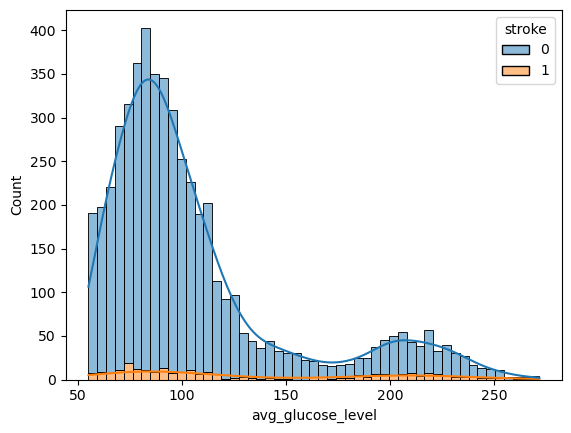

In [173]:
#sns.displot(df_PrePro.avg_glucose_level,height=4, aspect=1.5)
sns.histplot(x=('avg_glucose_level'),hue=('stroke'),multiple="stack",kde=True,data=df_glucose_outliers)
#plt.savefig("images/avg_glucose_level.png")
plt.show()

In [175]:
df_glucose_outliers.avg_glucose_level < 170

id
9046     False
51676    False
31112     True
60182    False
1665     False
         ...  
18234     True
44873     True
19723     True
37544     True
44679     True
Name: avg_glucose_level, Length: 5109, dtype: bool

In [177]:
df_no_outliers = df_glucose_outliers.loc[df_glucose_outliers.avg_glucose_level < 170,:]

C:\ProgramData\anaconda3\envs\env_strokepred\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\ProgramData\anaconda3\envs\env_strokepred\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\ProgramData\anaconda3\envs\env_strokepred\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


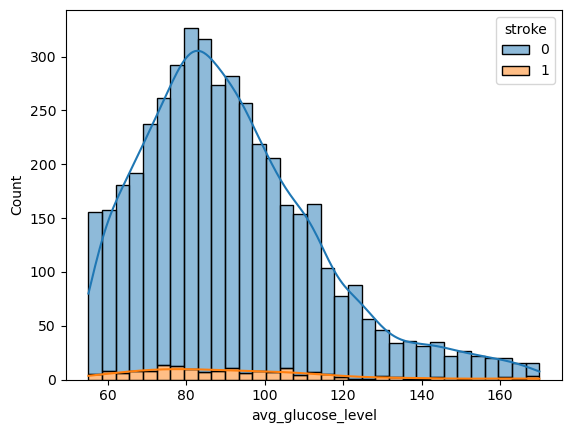

In [178]:
#sns.displot(df_PrePro.avg_glucose_level,height=4, aspect=1.5)
sns.histplot(x=('avg_glucose_level'),hue=('stroke'),multiple="stack",kde=True,data=df_no_outliers)
#plt.savefig("images/avg_glucose_NoOutlier.png")
plt.show()

In [180]:
#Data splitting
df_train_NoOutlier, df_test_NoOutlier = train_test_split(df_no_outliers,test_size = 0.2)

In [181]:
X_train_NoOutlier = df_train_NoOutlier.loc[:,['age','hypertension','heart_disease','avg_glucose_level']].values
y_train_NoOutlier = df_train_NoOutlier.stroke.values

In [182]:
X_test_NoOutlier = df_test_NoOutlier.loc[:,['age','hypertension','heart_disease','avg_glucose_level']].values
y_test_NoOutlier = df_test_NoOutlier.stroke.values

In [184]:
# here we initialize the model
lr_model_NoOutlier = LogisticRegression(random_state=0,max_iter=1000,class_weight='balanced')

In [185]:
# here we train the model on the training data
lr_model_NoOutlier.fit(X=X_train_NoOutlier, y=y_train_NoOutlier)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=0)

In [187]:
y_test_predicted_NoOutlier = lr_model_NoOutlier.predict(X_test_NoOutlier)

In [188]:
cf_NoOutlier = pd.DataFrame(
    columns=["y_test_0","y_test_1"],index=["y_pred_0","y_pred_1"]
)

In [189]:
cf_NoOutlier.loc[:,:] = confusion_matrix(y_true=y_test_NoOutlier,y_pred= y_test_predicted_NoOutlier)

In [190]:
cf_NoOutlier

,y_test_0,y_test_1
y_pred_0,654,215
y_pred_1,7,22


In [191]:
print(classification_report(y_true=y_test_NoOutlier, y_pred=y_test_predicted_NoOutlier))

              precision    recall  f1-score   support

           0       0.99      0.75      0.85       869
           1       0.09      0.76      0.17        29

    accuracy                           0.75       898
   macro avg       0.54      0.76      0.51       898
weighted avg       0.96      0.75      0.83       898



### SMOTE USE FOR OUTLIERS CANCELLING

In [192]:
smote=SMOTE()
train_x_NoOutlier,train_y_NoOutlier=smote.fit_resample(X_train_NoOutlier,y_train_NoOutlier)
test_x_NoOutlier,test_y_NoOutlier=smote.fit_resample(X_test_NoOutlier,y_test_NoOutlier)

print(train_x_NoOutlier.shape,train_y_NoOutlier.shape,test_x_NoOutlier.shape,test_y_NoOutlier.shape)

(6904, 4) (6904,) (1738, 4) (1738,)


In [193]:
# here we initialize the model
lr_model_NoOutlier = LogisticRegression(random_state=0,max_iter=1000,class_weight='balanced')

In [194]:
# here we train the model on the training data
lr_model_NoOutlier.fit(X=train_x_NoOutlier, y=train_y_NoOutlier)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=0)

In [195]:
test_predicted_y_NoOutlier = lr_model_NoOutlier.predict(test_x_NoOutlier)

In [196]:
print(classification_report(y_true=test_y_NoOutlier, y_pred=test_predicted_y_NoOutlier))

              precision    recall  f1-score   support

           0       0.75      0.76      0.76       869
           1       0.76      0.75      0.75       869

    accuracy                           0.75      1738
   macro avg       0.75      0.75      0.75      1738
weighted avg       0.75      0.75      0.75      1738



**With outliers report**

In [197]:
print(classification_report(test_y, predict_y))

              precision    recall  f1-score   support

           0       0.75      0.78      0.76       971
           1       0.77      0.74      0.75       971

    accuracy                           0.76      1942
   macro avg       0.76      0.76      0.76      1942
weighted avg       0.76      0.76      0.76      1942



The **macro avg** values have increased a bit. Recall for stroked has increase a bit too and so is for f1 score macro avg

### Checking for Decisional Tree and Random Frorest models

In [208]:
# Try a Decision Tree classifier
dt_model_NoOutlier = DecisionTreeClassifier()

In [209]:
dt_model_NoOutlier.fit(X=train_x_NoOutlier,y=train_y_NoOutlier)

DecisionTreeClassifier()

In [210]:
y_test_predicted_dt_NoOutlier = dt_model_NoOutlier.predict(test_x_NoOutlier)

In [211]:
report_dt_NoOutlier = classification_report(y_pred=y_test_predicted_dt_NoOutlier,y_true=test_y_NoOutlier)

In [212]:
print(report_dt_NoOutlier)

              precision    recall  f1-score   support

           0       0.70      0.95      0.81       869
           1       0.92      0.60      0.73       869

    accuracy                           0.78      1738
   macro avg       0.81      0.78      0.77      1738
weighted avg       0.81      0.78      0.77      1738



In [234]:
#Former DT results
print("Report of Decision Tree classifier model")
print(report_dt)

Report of Decision Tree classifier model
              precision    recall  f1-score   support

           0       0.69      0.93      0.79       971
           1       0.90      0.58      0.71       971

    accuracy                           0.76      1942
   macro avg       0.79      0.76      0.75      1942
weighted avg       0.79      0.76      0.75      1942



**Conclusion for Decisional Tree: Better improvement after outliers cancelling**

In [213]:
# Try an ensemble classifier: Random Forest
rf_model_NoOutlier = RandomForestClassifier()

In [214]:
rf_model_NoOutlier.fit(X=train_x_NoOutlier,y=train_y_NoOutlier)

RandomForestClassifier()

In [215]:
y_test_predicted_rf_NoOutlier = rf_model_NoOutlier.predict(test_x_NoOutlier)

In [216]:
report_rf_NoOutlier = classification_report(y_pred=y_test_predicted_rf,y_true=test_y_NoOutlier)

In [217]:
print(report_rf_NoOutlier)

              precision    recall  f1-score   support

           0       0.72      0.95      0.82       869
           1       0.93      0.63      0.75       869

    accuracy                           0.79      1738
   macro avg       0.82      0.79      0.79      1738
weighted avg       0.82      0.79      0.79      1738



In [235]:
#Former RF results
print("Report of Random Forest model")
print(report_rf)

Report of Random Forest model
              precision    recall  f1-score   support

           0       0.71      0.96      0.82       971
           1       0.93      0.61      0.74       971

    accuracy                           0.78      1942
   macro avg       0.82      0.78      0.78      1942
weighted avg       0.82      0.78      0.78      1942



**Conclusion for Random Forest: not better improvement after outliers cancelling**

## General Conclusion

In general the **Decisional Tree Model** seems the best after data adjustment with SMOTE and average glucose level outliers cancelling.
The Logistic Regression model is also improved a little bit.

The small size of the dataset, data imbalance and outliers  have definitely negative impact on the model training.

The decisional tree final model will be saved on disk for further use of its current parameters

### Saving the model on and Reading from the disk

In [236]:
# save the iris classification model as a pickle file
model_pkl_file = "model/stroke_DecisTree_model.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(dt_model_NoOutlier, file)

In [240]:
model_pkl_file = "model/stroke_DecisTree_model.pkl"
# load model from pickle file
with open(model_pkl_file, 'rb') as file:  
    model_dsk = pickle.load(file)

# evaluate model 
predict_y = model_dsk.predict(test_x_NoOutlier)

# check results
print(classification_report(test_y_NoOutlier,predict_y)) 

              precision    recall  f1-score   support

           0       0.70      0.95      0.81       869
           1       0.92      0.60      0.73       869

    accuracy                           0.78      1738
   macro avg       0.81      0.78      0.77      1738
weighted avg       0.81      0.78      0.77      1738

